In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2023-09-11 05:08:36.004930: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-11 05:08:36.011522: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 05:08:36.297190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-11 05:08:36.312404: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 05:08:39.116713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load the data
data = pd.read_csv('node3_data.csv')

In [3]:
data['needs_charge'] = np.where(data['charge'] <= 50, 1, 0)

DATA CLEANING

In [4]:
# Data Cleaning
data = pd.get_dummies(data, columns=['weather', 'traffic', 'road_gradient', 'emergency', 'car_status'])

# Check the column names
print(data.columns)

Index(['timestamp', 'car_id', 'model', 'current_speed', 'battery_capacity',
       'charge', 'consumption', 'location', 'node', 'distance_covered',
       'battery_life', 'distance_to_charging_point', 'emergency_duration',
       'needs_charge', 'weather_rainy', 'weather_snowy', 'weather_sunny',
       'traffic_heavy', 'traffic_light', 'traffic_moderate',
       'road_gradient_downhill', 'road_gradient_flat', 'road_gradient_uphill',
       'emergency_accident_ahead', 'emergency_none', 'emergency_road_closure',
       'car_status_Charging', 'car_status_Moving', 'car_status_moving',
       'car_status_rerouting', 'car_status_stopped'],
      dtype='object')


In [5]:
## Remove duplicates
data = data.drop_duplicates()

# Drop other non-numeric columns if any
data = data.select_dtypes(include=[float, int])

In [6]:
## Handle outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

for column in data.columns:
    median = data[column].median()
    data.loc[((data[column] < (Q1[column] - 1.5 * IQR[column])) | (data[column] > (Q3[column] + 1.5 * IQR[column]))), column] = median

Feature Selection

In [7]:
# Feature Selection
features = ['current_speed', 'battery_capacity', 'charge', 'consumption', 'distance_covered', 'battery_life', 'distance_to_charging_point']
features += [col for col in data if 'weather_' in col]
features += [col for col in data if 'traffic_' in col]
features += [col for col in data if 'road_gradient_' in col]
features += [col for col in data if 'emergency_' in col]
features += [col for col in data if 'car_status_' in col]

X = data[features]
y = data['needs_charge']

print(X.head())

   current_speed  battery_capacity     charge  consumption  distance_covered  \
0             18                38  88.302349         0.09         10.733333   
1             34                38  88.166650         0.09         11.666667   
2             31                38  88.117800         0.09         12.233333   
3             34                38  88.077429         0.09         12.750000   
4             29                38  88.028579         0.09         13.316667   

   battery_life  distance_to_charging_point  emergency_duration  
0        99.984                  179.266667                   0  
1        99.983                  178.333333                   0  
2        99.982                  177.766667                   0  
3        99.981                  177.250000                   0  
4        99.980                  176.683333                   0  


In [8]:
# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize the model with higher max_iter
model = LogisticRegression(max_iter=1000)

# Initialize RFE
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
fit = rfe.fit(X, y)

# Get the selected features
selected_features = X.columns[fit.support_]
print("Selected Features: ", selected_features)

Selected Features:  Index(['current_speed', 'battery_capacity', 'charge', 'consumption',
       'distance_covered', 'battery_life', 'distance_to_charging_point',
       'emergency_duration'],
      dtype='object')


In [9]:
print(data['charge'].describe())
print(data['needs_charge'].value_counts())


count    11440.000000
mean        59.000841
std         17.137428
min         30.002793
25%         44.383754
50%         56.848159
75%         72.954624
max         97.928554
Name: charge, dtype: float64
needs_charge
0    7317
1    4123
Name: count, dtype: int64


In [10]:
print(data['needs_charge'].value_counts())

needs_charge
0    7317
1    4123
Name: count, dtype: int64


In [11]:
# # Data Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Data Splitting using selected features
X_selected = X[selected_features]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [12]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Data Visualization

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


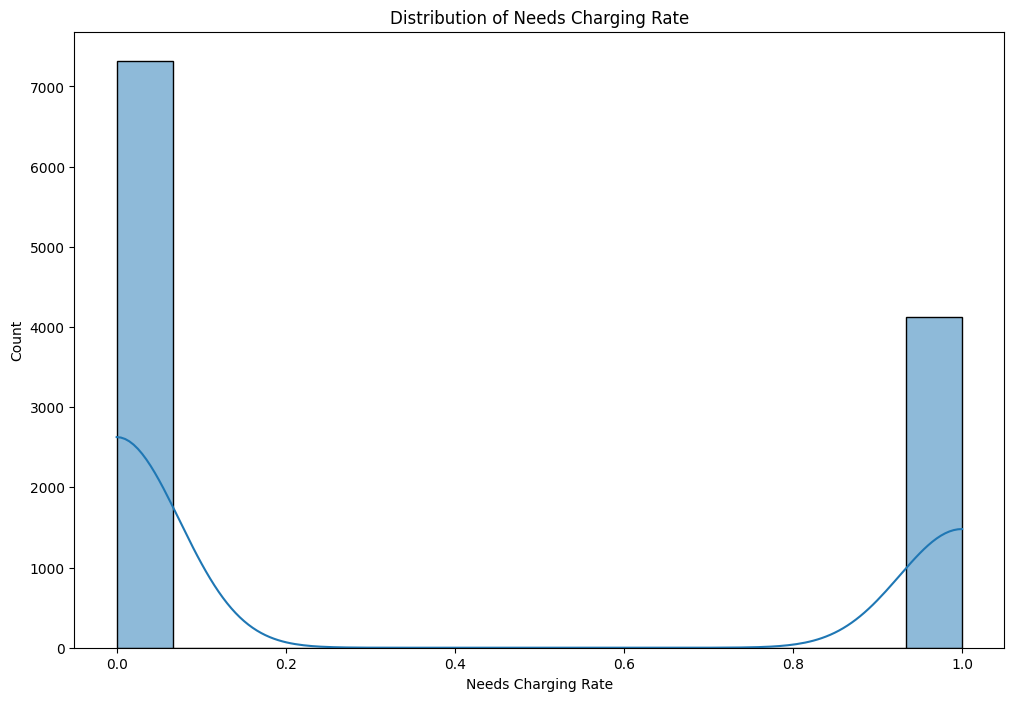

In [13]:
# Distribution of the target variable
plt.figure(figsize=(12,8))
sns.histplot(data['needs_charge'], kde=True)
plt.title('Distribution of Needs Charging Rate')
plt.xlabel('Needs Charging Rate')
plt.ylabel('Count')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


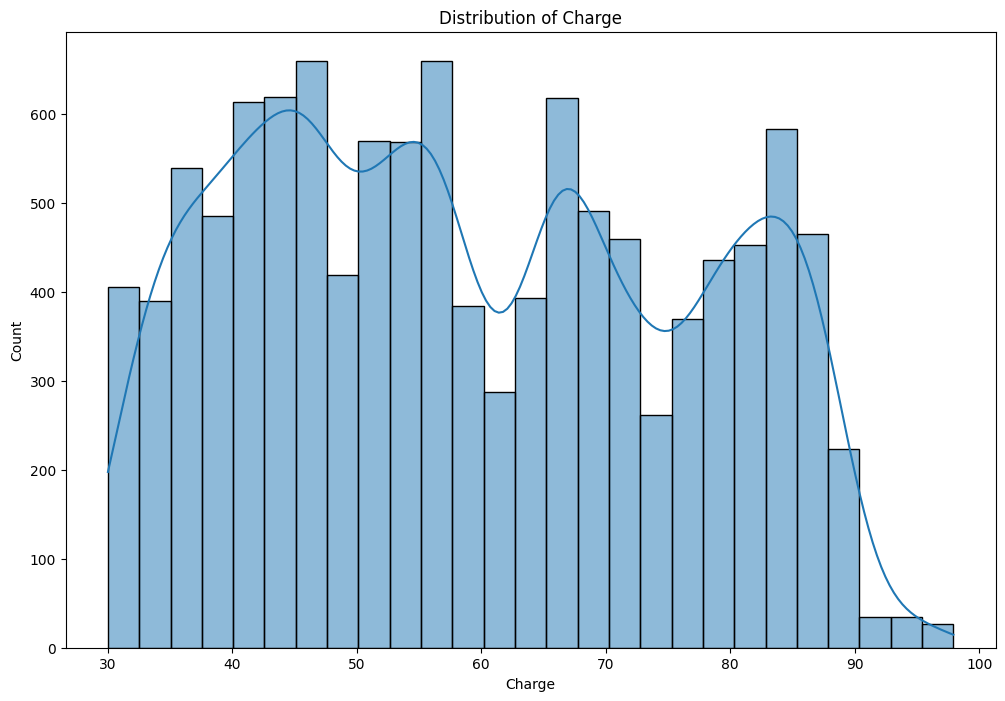

In [14]:
# plot the distribution 
plt.figure(figsize=(12,8))
sns.histplot(data['charge'], kde=True)
plt.title('Distribution of Charge')
plt.xlabel('Charge')
plt.ylabel('Count')
plt.show()


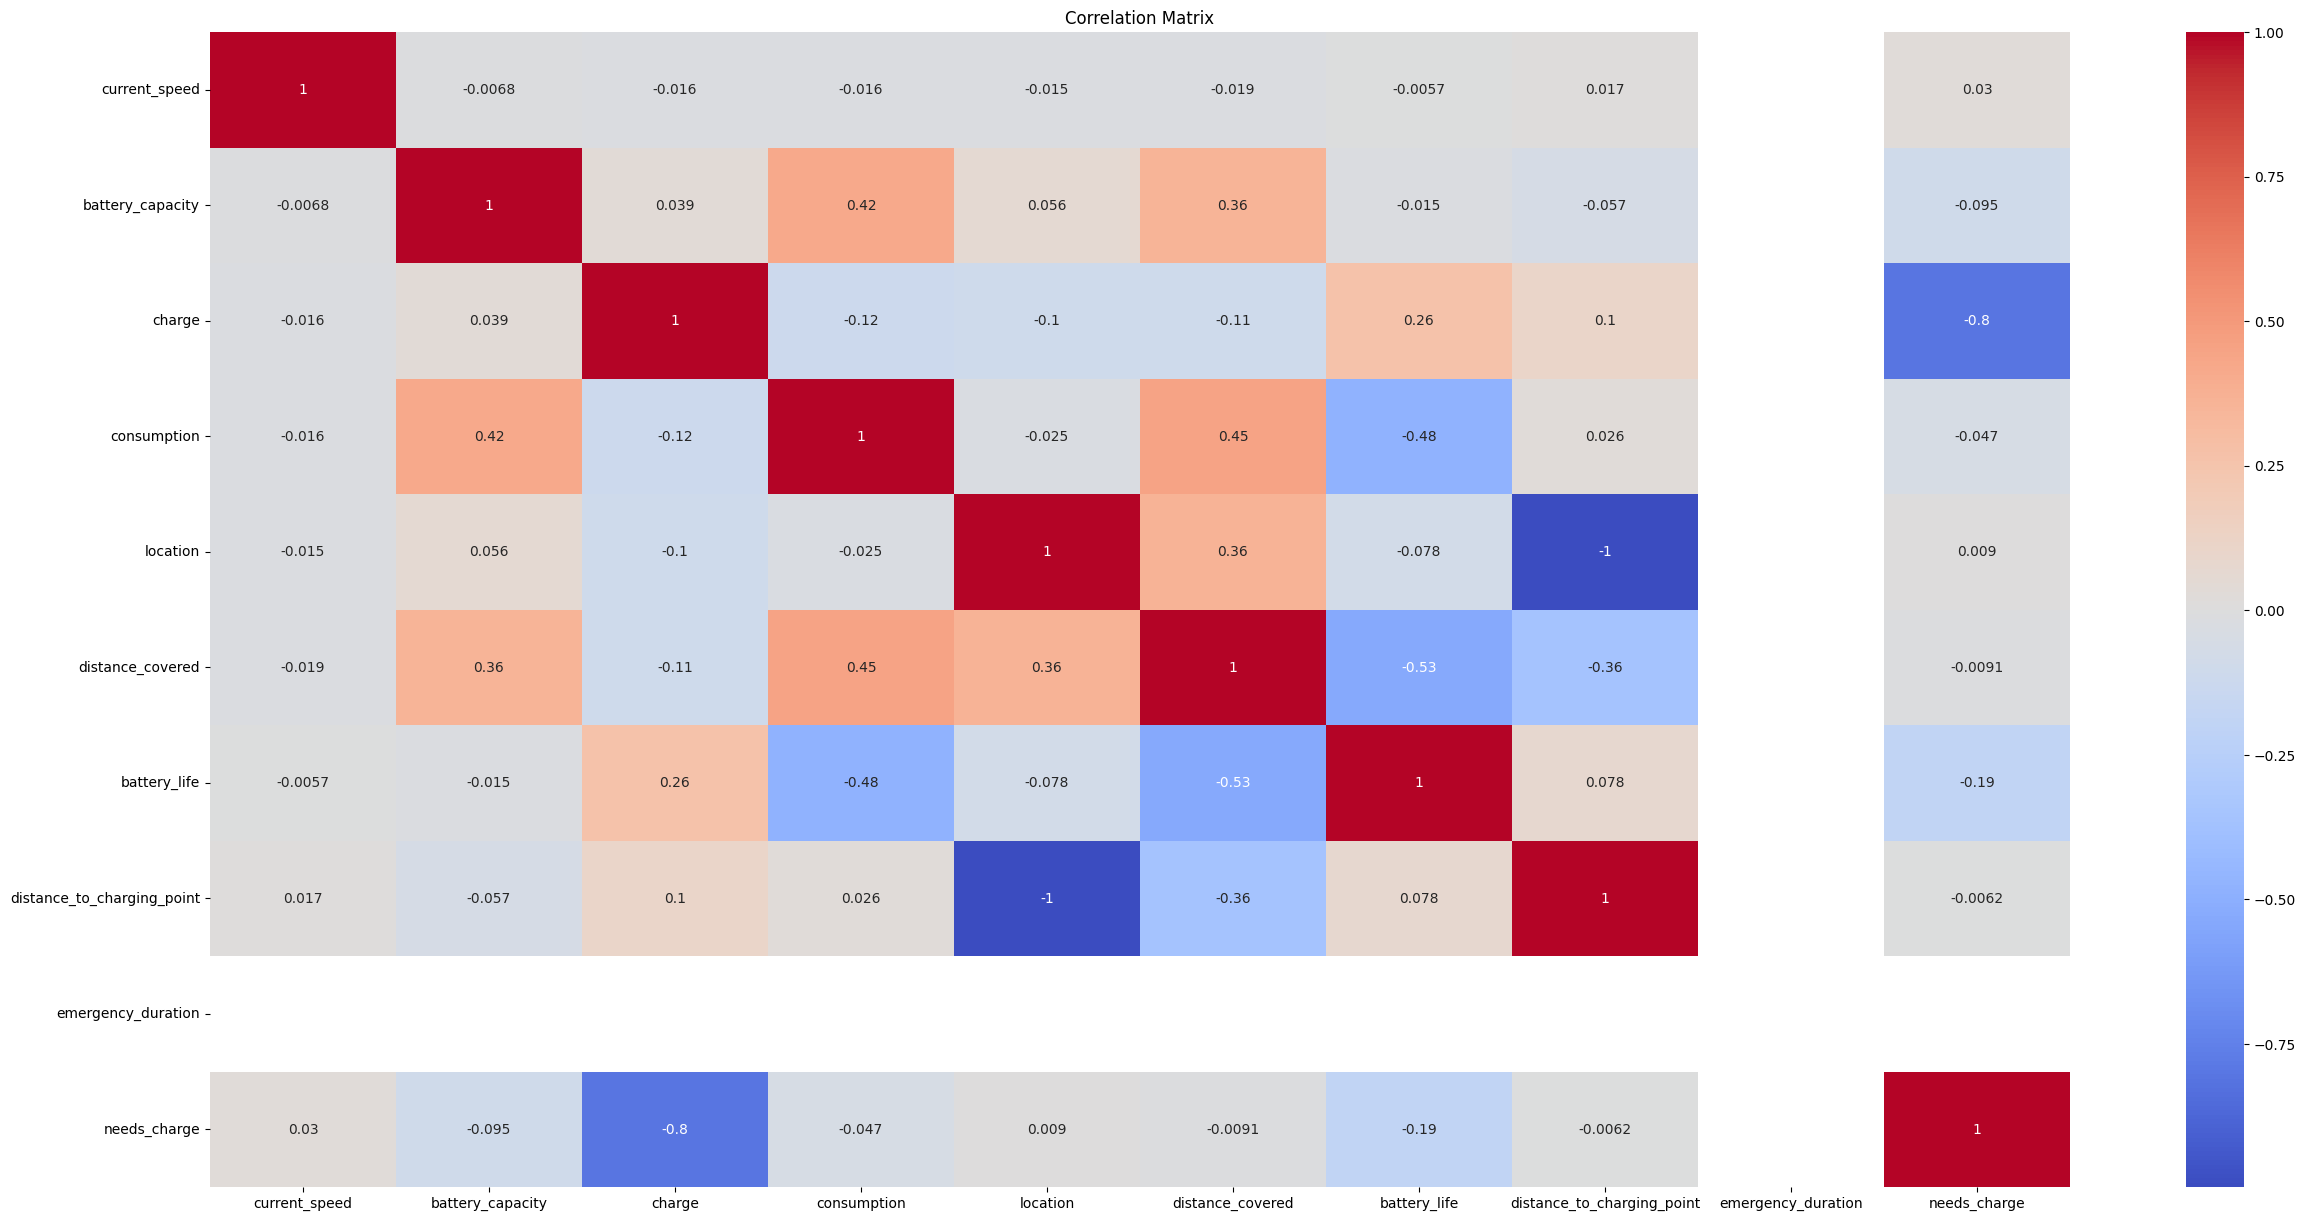

In [15]:
## Correlation Analysis
correlation_matrix = data.corr()
plt.figure(figsize=(30,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

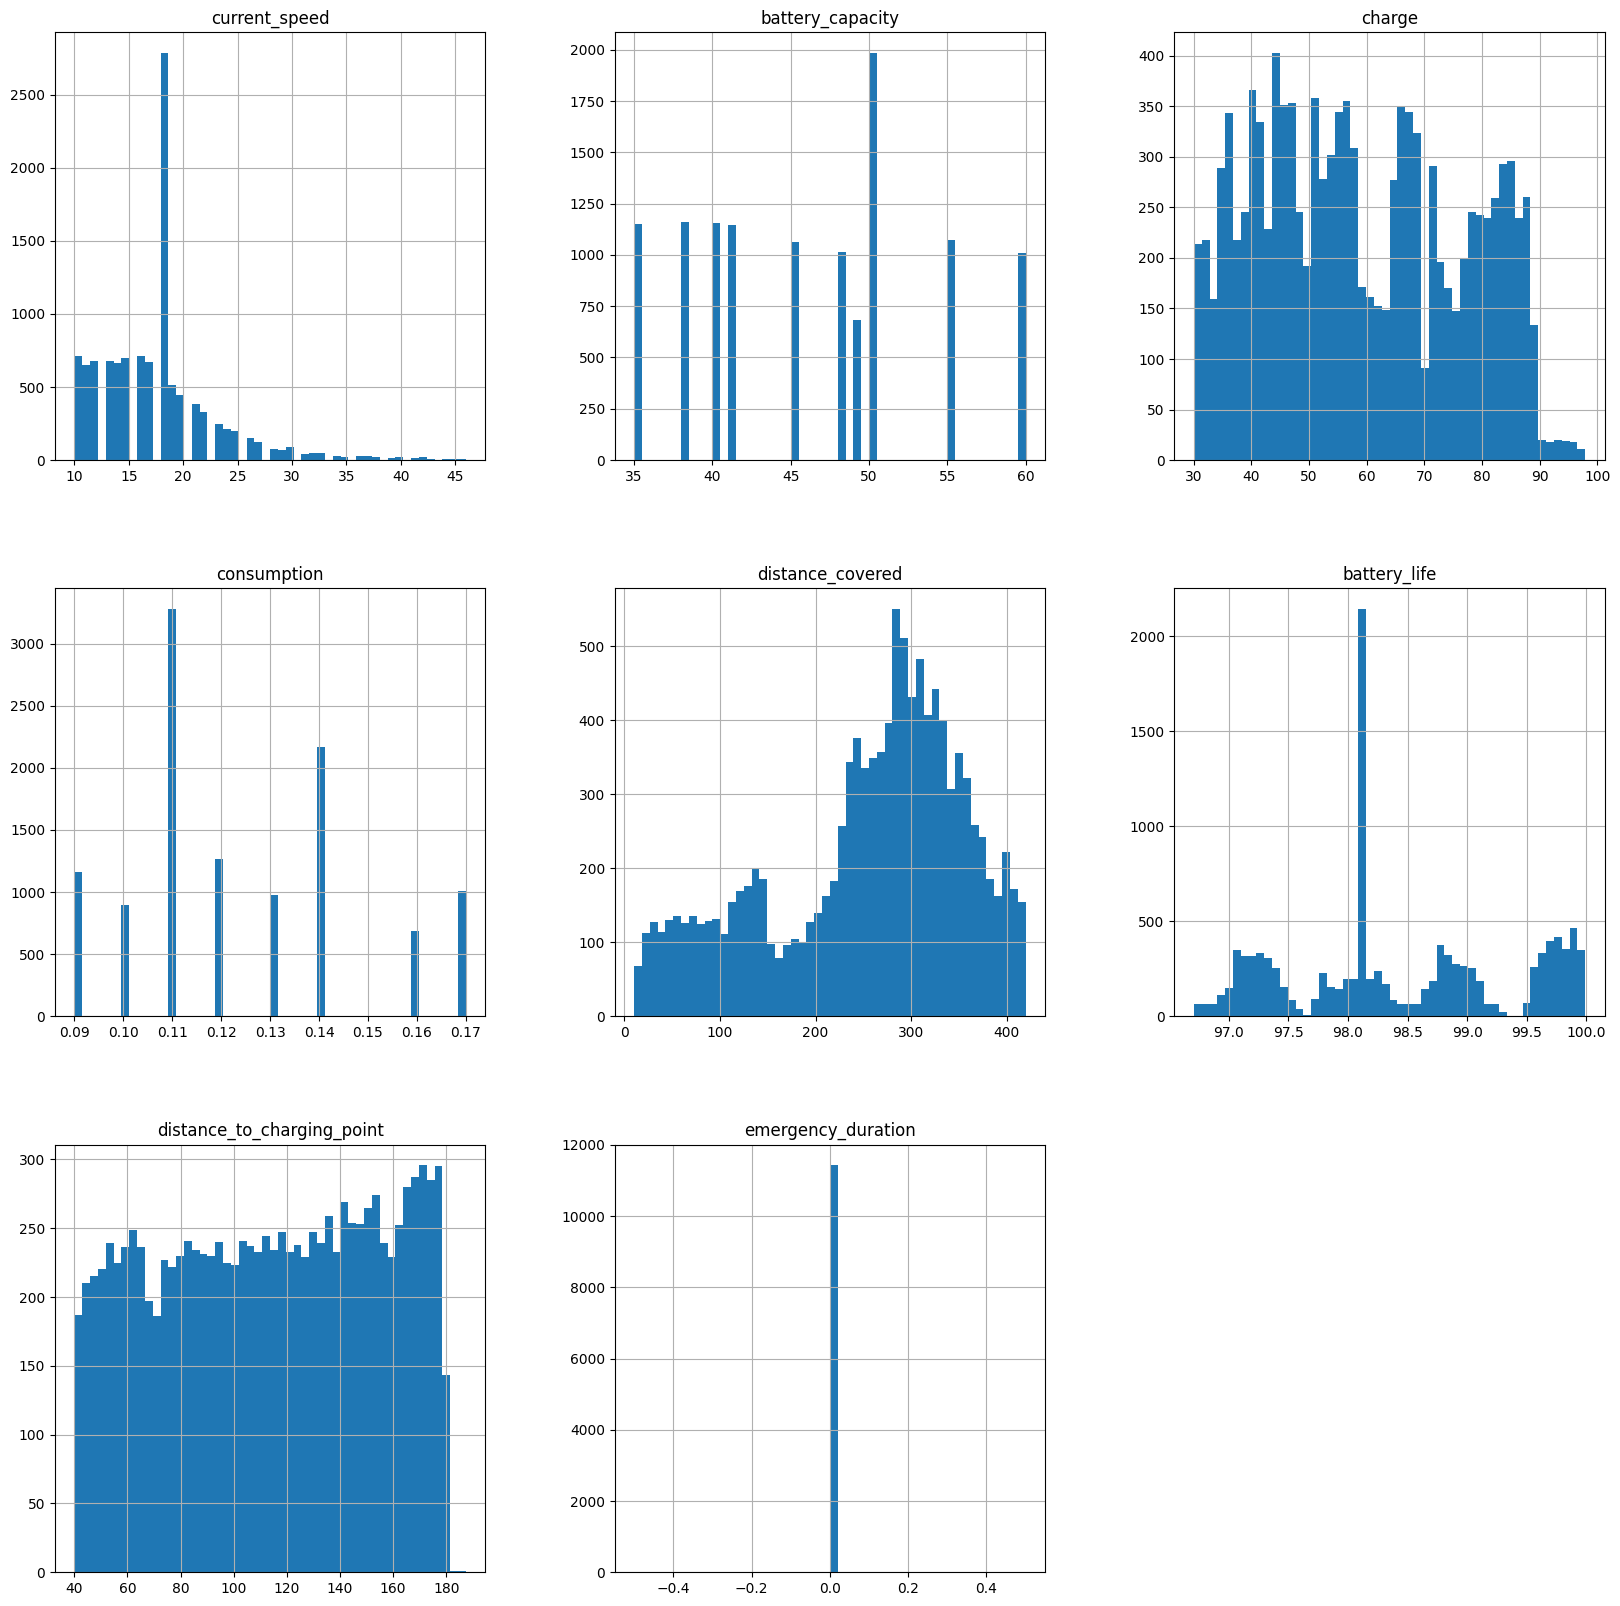

In [16]:
# Visualizing the distribution of the features
data[features].hist(figsize=(20, 20), bins=50)
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

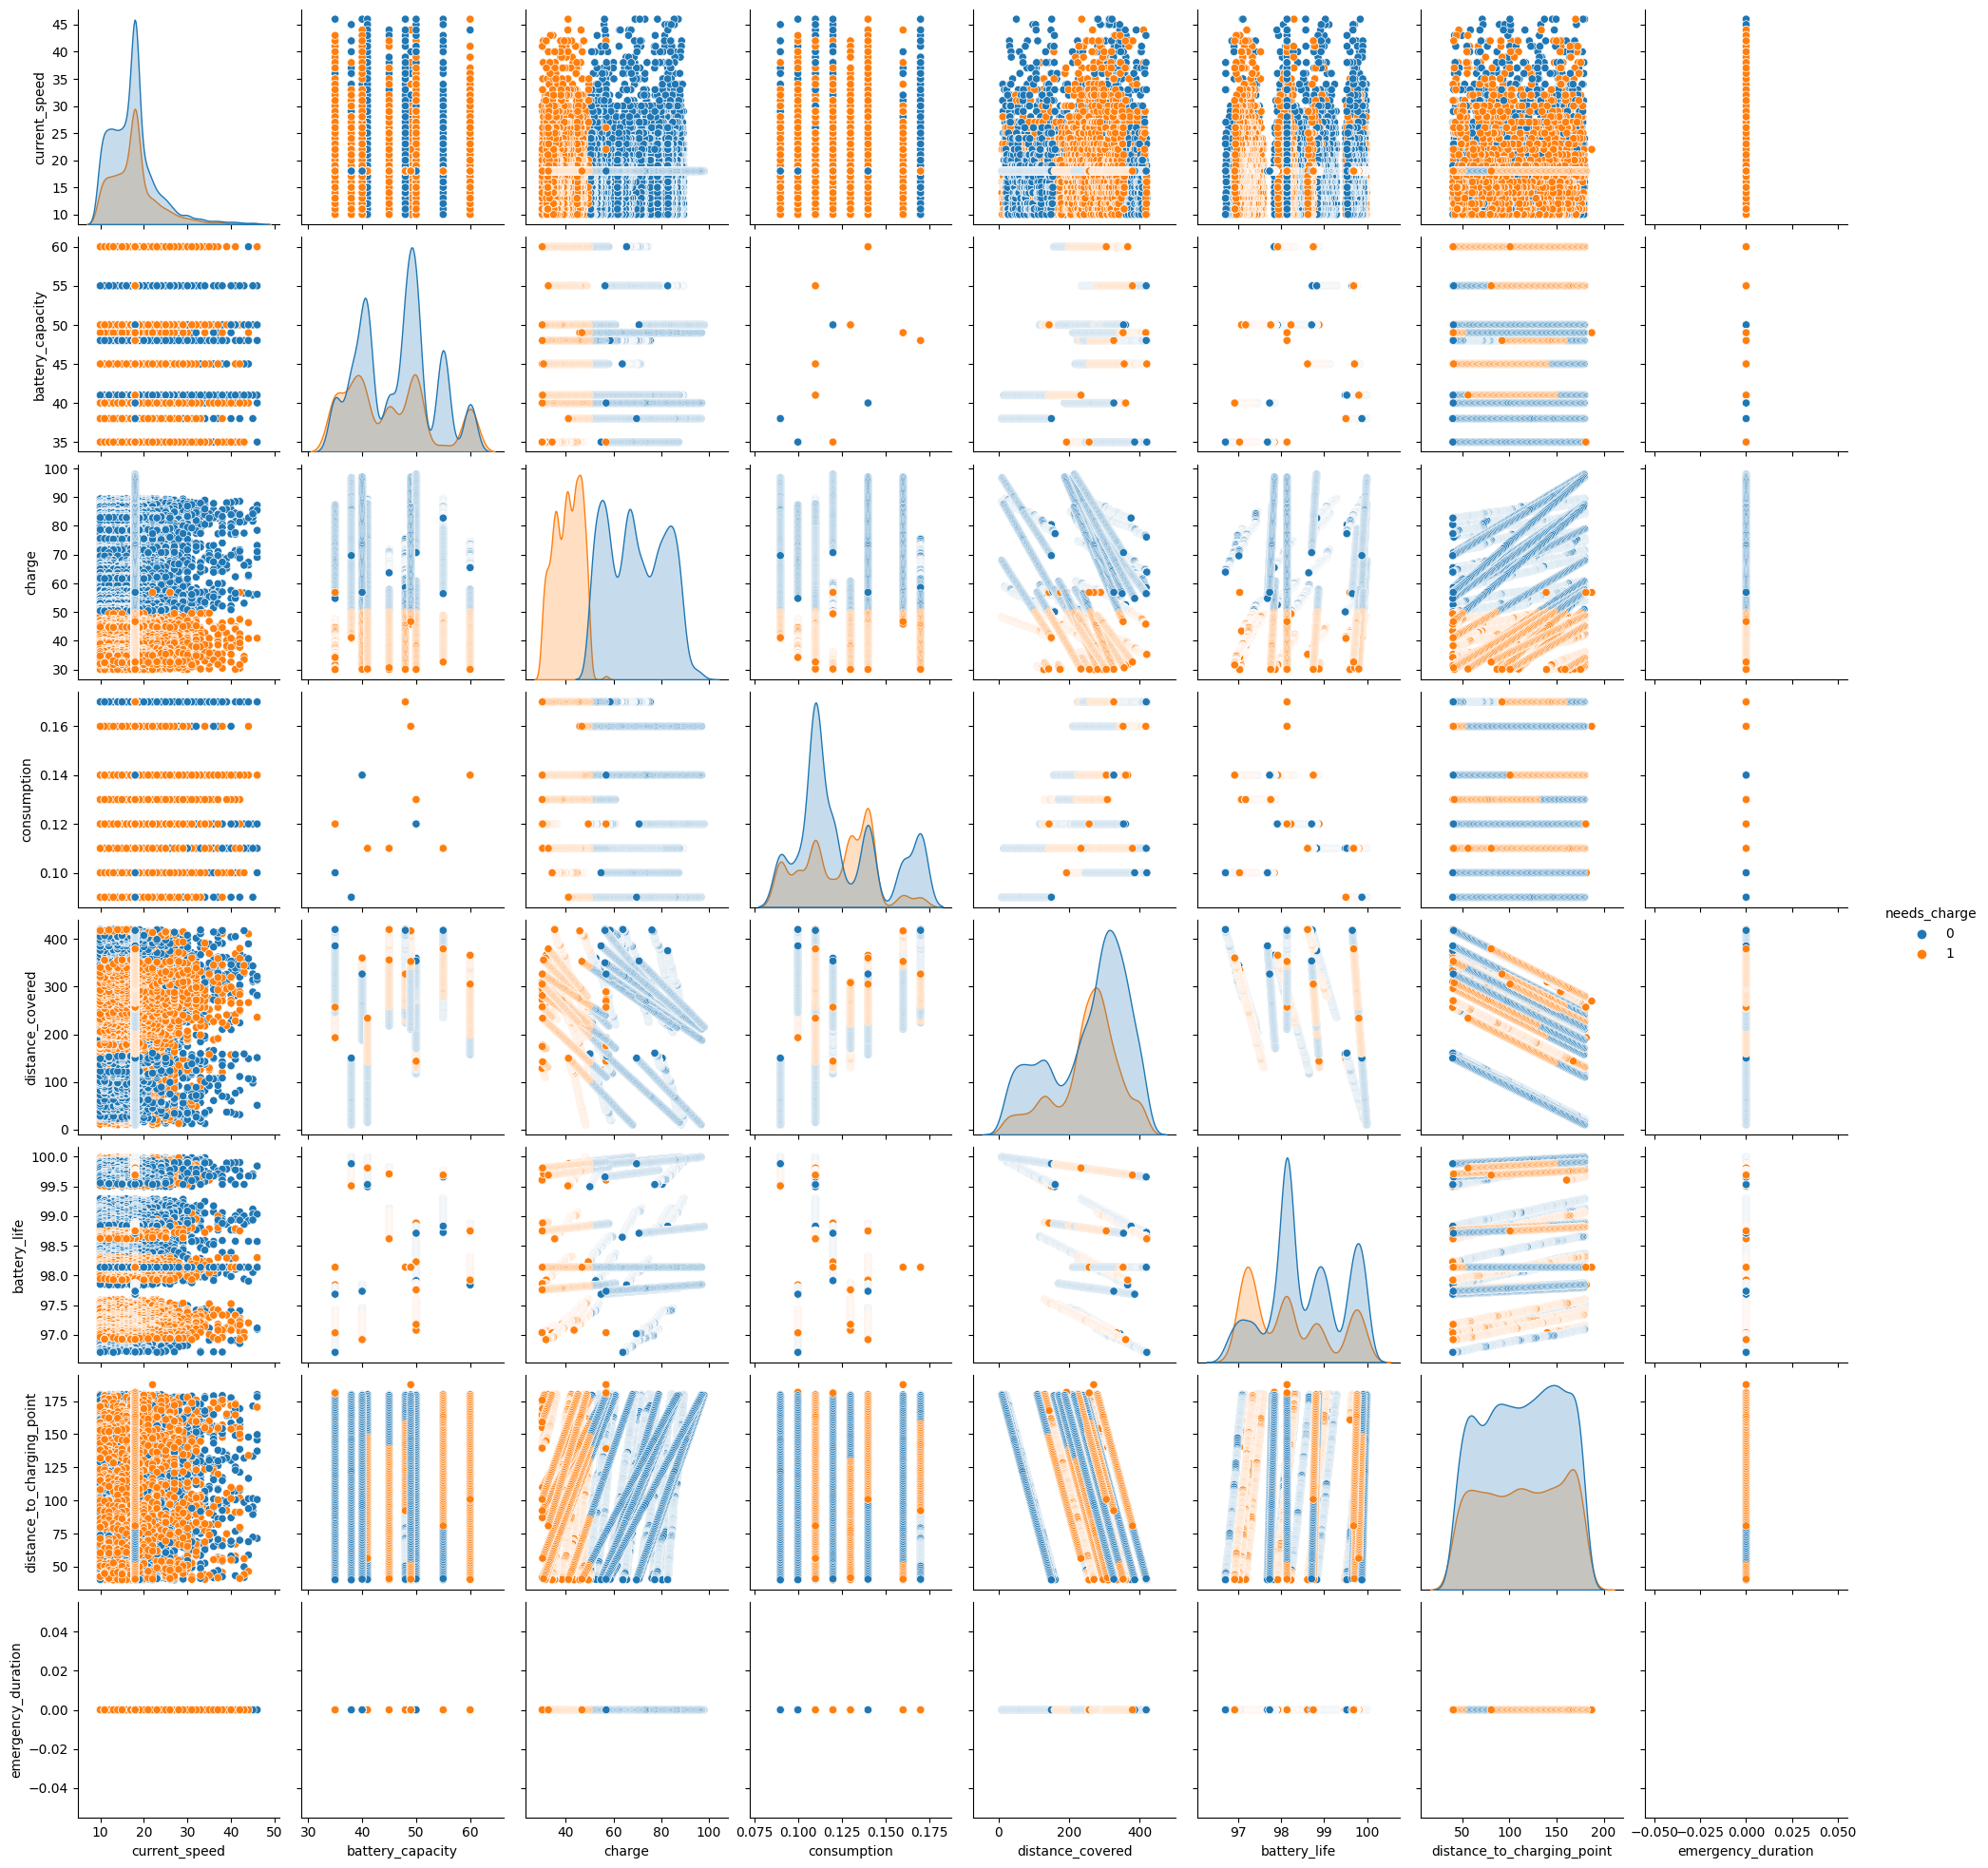

In [17]:
# Pairplot of the features and target variable
sns.pairplot(data[features + ['needs_charge']], hue='needs_charge')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

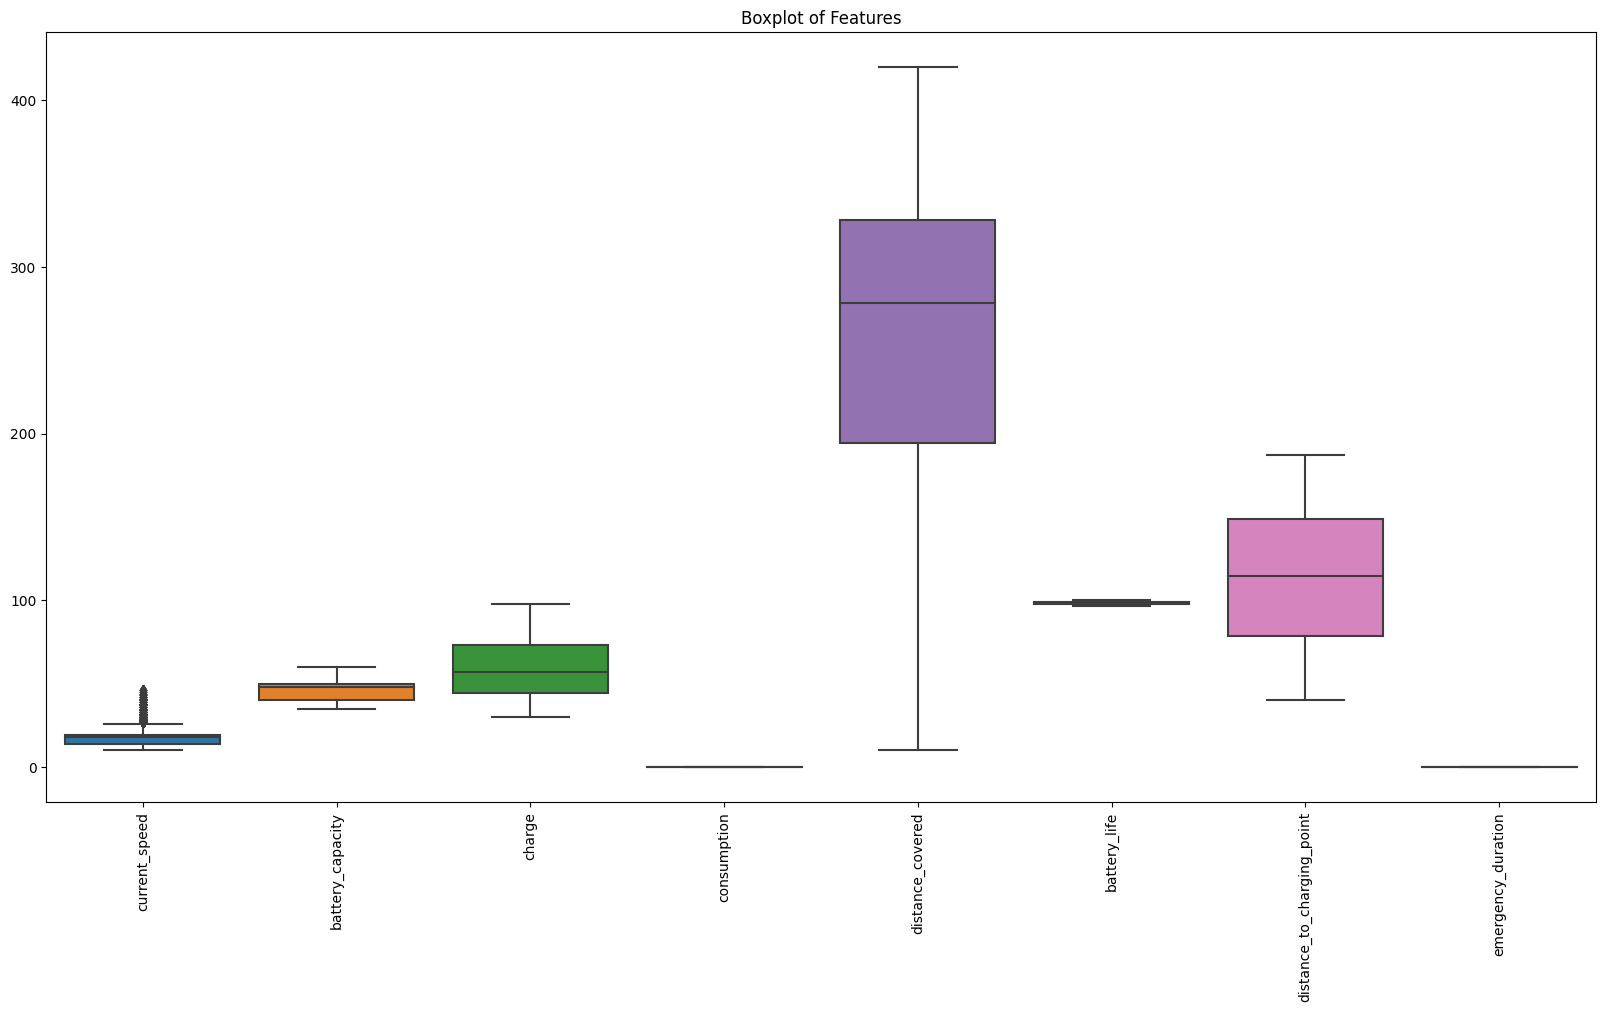

In [18]:
# Boxplots for each feature
plt.figure(figsize=(20, 10))
sns.boxplot(data=data[features])
plt.title('Boxplot of Features')
plt.xticks(rotation=90)
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

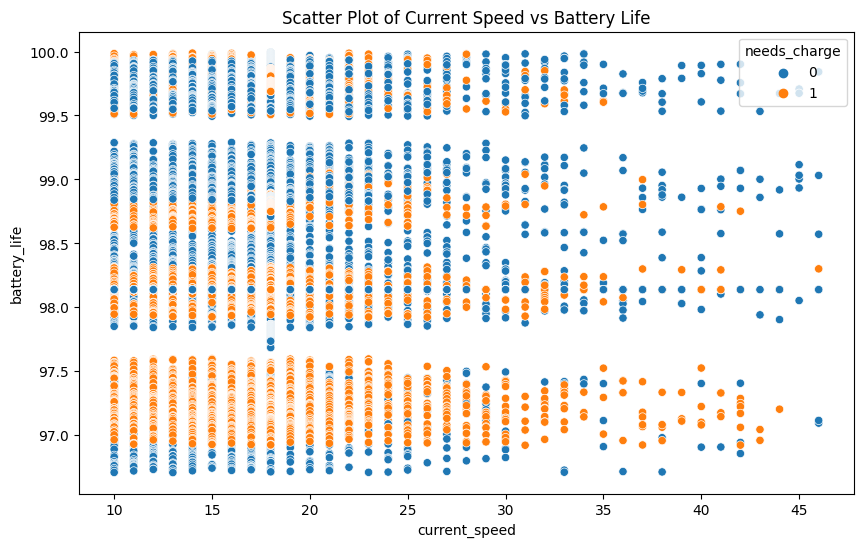

In [19]:
# Scatter plots
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='needs_charge')
plt.title('Scatter Plot of Current Speed vs Battery Life')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


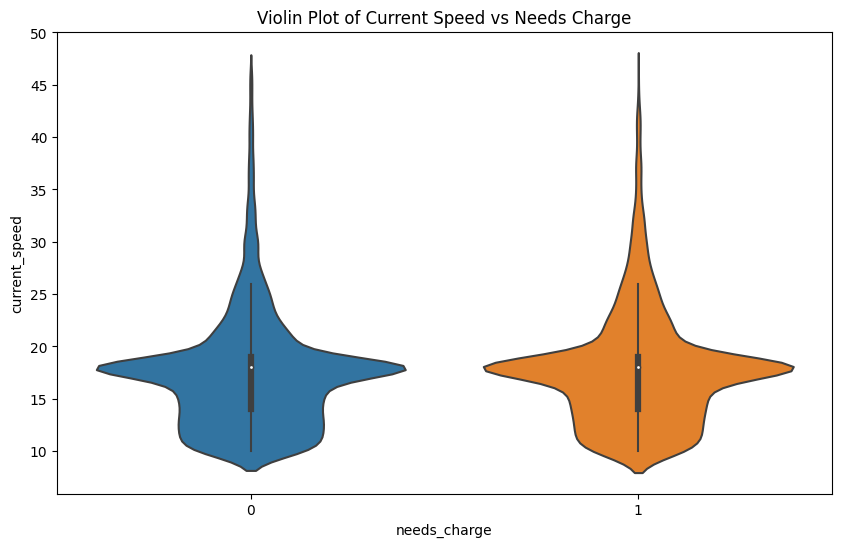

In [20]:
# Violin plots
plt.figure(figsize=(10, 6))
sns.violinplot(x=data['needs_charge'], y=data['current_speed'])
plt.title('Violin Plot of Current Speed vs Needs Charge')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

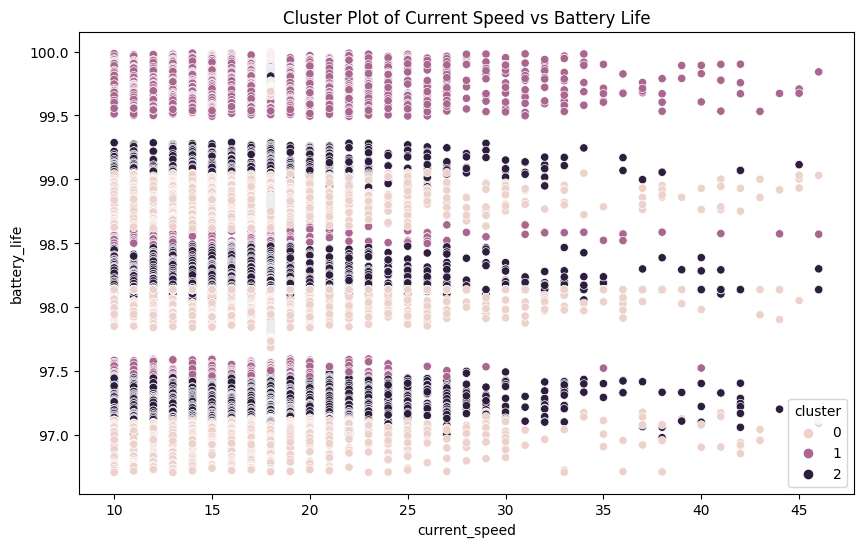

In [21]:
# cluster plot
from sklearn.cluster import KMeans

# Fit the KMeans algorithm to the data
kmeans = KMeans(n_clusters=3)
data['cluster'] = kmeans.fit_predict(data[features])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='current_speed', y='battery_life', hue='cluster')
plt.title('Cluster Plot of Current Speed vs Battery Life')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

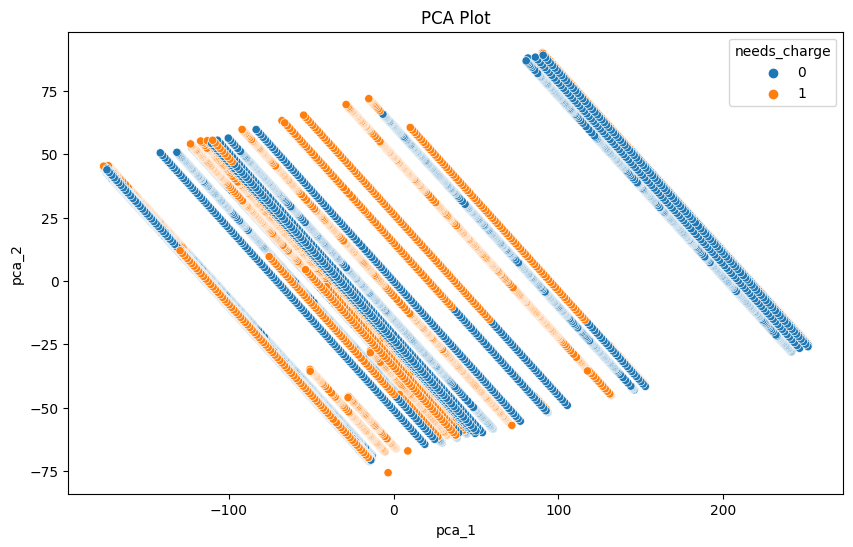

In [22]:
# Dimensionality reduction plot
from sklearn.decomposition import PCA

# Apply PCA to the data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])
data['pca_1'] = pca_result[:, 0]
data['pca_2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='pca_1', y='pca_2', hue='needs_charge')
plt.title('PCA Plot')
plt.show()

/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/maith/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.

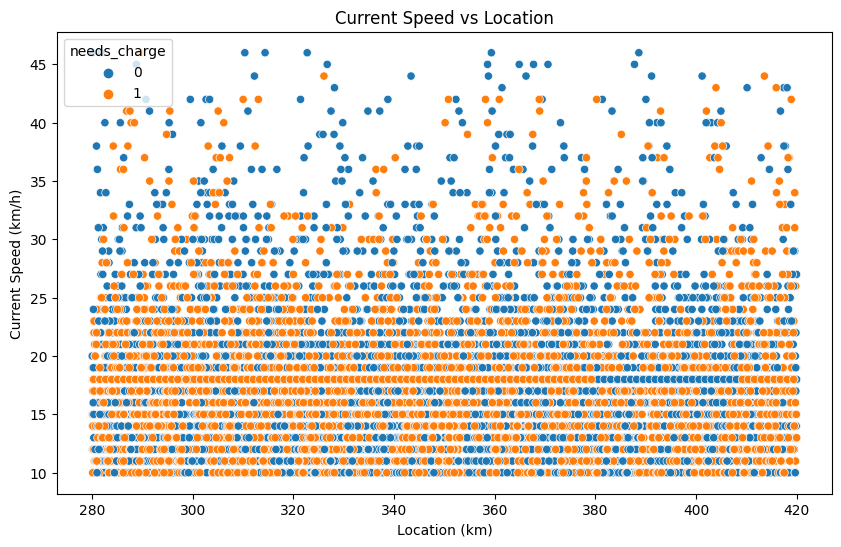

In [23]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='location', y='current_speed', hue='needs_charge')
plt.title('Current Speed vs Location')
plt.xlabel('Location (km)')
plt.ylabel('Current Speed (km/h)')
plt.show()

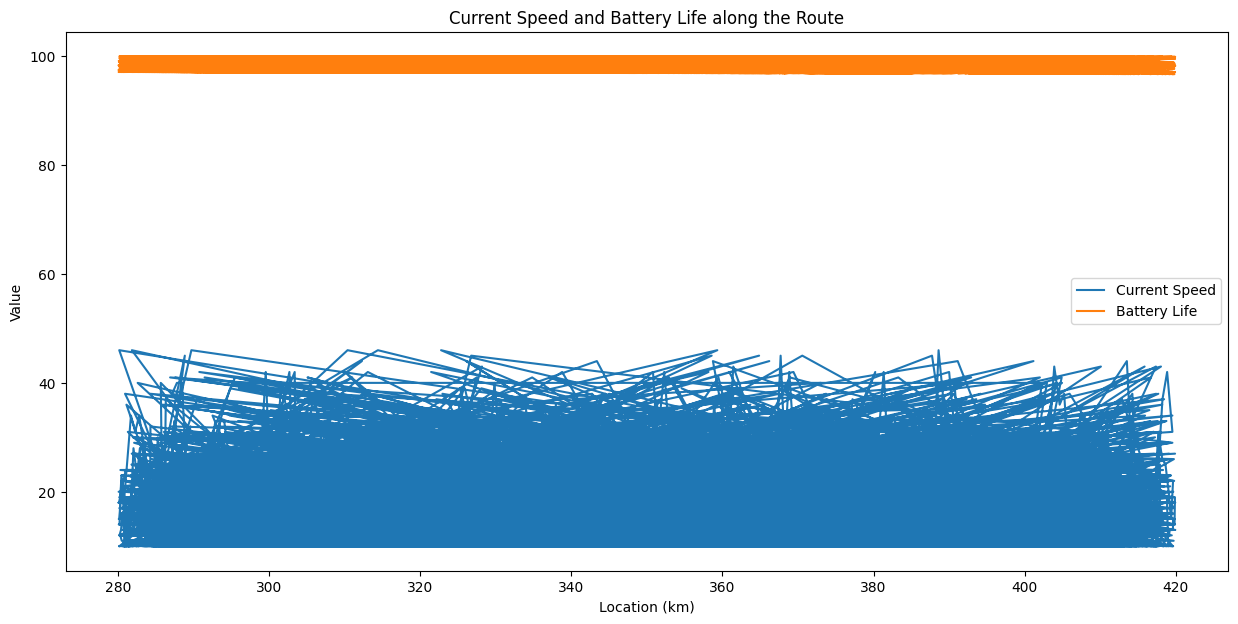

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(data['location'], data['current_speed'], label='Current Speed')
plt.plot(data['location'], data['battery_life'], label='Battery Life')
plt.title('Current Speed and Battery Life along the Route')
plt.xlabel('Location (km)')
plt.ylabel('Value')
plt.legend()
plt.show()

Random Forest Classifier

In [25]:
# Build the model
from sklearn.ensemble import RandomForestClassifier

In [26]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [27]:
# Create a based model
rf = RandomForestClassifier(random_state=42)

In [28]:
# Instantiate the grid search model
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [29]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   5.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total tim

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=2)

In [30]:
# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters: ", best_params)

Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [31]:
# Train the model with the best parameters
model = grid_search.best_estimator_

In [32]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

In [33]:
y_pred = model.predict(X_test)

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2167
           1       1.00      1.00      1.00      1265

    accuracy                           1.00      3432
   macro avg       1.00      1.00      1.00      3432
weighted avg       1.00      1.00      1.00      3432



In [36]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2167
           1       1.00      1.00      1.00      1265

    accuracy                           1.00      3432
   macro avg       1.00      1.00      1.00      3432
weighted avg       1.00      1.00      1.00      3432



In [37]:
# %%
from sklearn.model_selection import cross_val_score

# Use cross_val_score function
# Cross-Validation
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print('Cross-Validation Accuracy Scores', scores)
print('Average Cross-Validation Accuracy', scores.mean())


Cross-Validation Accuracy Scores [0.97814685 0.99825175 1.         1.         0.99912587 1.
 1.         1.         0.9965035  0.99912587]
Average Cross-Validation Accuracy 0.9971153846153846


In [38]:
# Initialize the constructor
model = Sequential()

In [39]:
# Add an input layer 
model.add(Dense(12, activation='relu', input_shape=(len(X.columns),)))

In [40]:
# Add one hidden layer 
model.add(Dense(8, activation='relu'))

In [41]:
# Add an output layer 
model.add(Dense(1, activation='sigmoid'))

In [42]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                108       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Define the callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             ModelCheckpoint(filepath='best_model.h5', save_best_only=True)]

In [45]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, 
          validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100


251/251 [==============================] - 3s 5ms/step - loss: 0.5065 - accuracy: 0.7526 - val_loss: 0.3345 - val_accuracy: 0.9036
Epoch 2/100
 67/251 [=======>......................] - ETA: 0s - loss: 0.2891 - accuracy: 0.9090

/home/maith/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


251/251 [==============================] - 1s 3ms/step - loss: 0.2090 - accuracy: 0.9418 - val_loss: 0.1285 - val_accuracy: 0.9682
Epoch 3/100
251/251 [==============================] - 2s 8ms/step - loss: 0.0931 - accuracy: 0.9836 - val_loss: 0.0656 - val_accuracy: 0.9866
Epoch 4/100
251/251 [==============================] - 2s 9ms/step - loss: 0.0519 - accuracy: 0.9900 - val_loss: 0.0443 - val_accuracy: 0.9875
Epoch 5/100
251/251 [==============================] - 2s 9ms/step - loss: 0.0364 - accuracy: 0.9920 - val_loss: 0.0337 - val_accuracy: 0.9901
Epoch 6/100
251/251 [==============================] - 2s 9ms/step - loss: 0.0293 - accuracy: 0.9929 - val_loss: 0.0286 - val_accuracy: 0.9930
Epoch 7/100
251/251 [==============================] - 2s 9ms/step - loss: 0.0250 - accuracy: 0.9946 - val_loss: 0.0265 - val_accuracy: 0.9924
Epoch 8/100
251/251 [==============================] - 2s 9ms/step - loss: 0.0223 - accuracy: 0.9945 - val_loss: 0.0243 - val_accuracy: 0.9939
Epoch 9/100

In [46]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

108/108 [==============================] - 0s 2ms/step - loss: 0.0125 - accuracy: 0.9974
Test loss: 0.012454497627913952
Test accuracy: 0.9973776340484619


In [47]:
def predict_need_charge(model, scaler, features):
    # print feature names and their values
       
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    80,  # current_speed
    35,  # battery_capacity
    45,  # charge
    0.1,  # consumption
    100,  # distance_covered
    100,  # battery_life
    5,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")

/home/maith/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 141ms/step
The car needs to charge in the next station.


In [48]:
# Save the Random Forest model
joblib.dump(grid_search.best_estimator_, 'random_forest_model_node_3.pkl')

# save Neural Network model
model.save('neural_network_model_node_3.h5')

# save scaler object
joblib.dump(scaler, 'scaler_node_3.pkl')

/home/maith/.local/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler_node_3.pkl']

In [49]:
# load Random Forest model
model = joblib.load('random_forest_model_node_3.pkl')

# load Neural Network model
model = tf.keras.models.load_model('neural_network_model_node_3.h5')

# load scaler object
scaler = joblib.load('scaler_node_3.pkl')

In [50]:
def predict_need_charge(model, scaler, features):
    # scale the features
    features_scaled = scaler.transform(np.array(features).reshape(1, -1))
    # make prediction
    prediction = model.predict(features_scaled)
    return int(prediction.round())

features = [
    80,  # current_speed
    35,  # battery_capacity
    55,  # charge
    0.1,  # consumption
    100,  # distance_covered
    100,  # battery_life
    5,   # distance_to_charging_point
    0    # emergency_duration
]

prediction = predict_need_charge(model, scaler, features)
if prediction == 1:
    print("The car needs to charge in the next station.")
else:
    print("The car does not need to charge in the next station.")


/home/maith/.local/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 78ms/step
The car needs to charge in the next station.
